<img src = "https://www.tilburguniversity.edu/upload/c67b70dd-9a4f-499b-82e0-0aee20dfe12a_jads%20logo.png",width=500>

<center><h1>House Prices: Advanced Regression Techniques</h1>
<h4>by Maarten Grootendorst (JADS_MaartenG@Kaggle)</h4></center>

### Goal
The dataset contains 79 explanatory variables that describe alsmost every aspect of residential homes in Ames, Iowa. It's up to me to predict the pricing of houses based on the given dataset. The data is split into a train and test data set for me to train and test on. This dataset is part of a kaggle competition in which the principles of stacking, blending and ensembling techniques can be learned. Furthermore, for this dataset (as you will see) feature engineering will be crucial to getting a better RMSE. 

*Main problem of dataset*:  
There seems to be some underlying problem with this dataset: missing values. The amount of training data is very small, so filling in the missing data is important to increase the accuracy of the model. Thus, it may be that feature engineering/feature selection and missing data imputation are more important than modelling. 

 **Table of Contents**
 
1. [Installing/Loading Packages](#packages)
    
2. [Reading Data](#data)

3. [Visualization](#visualization) 

4. [Data Preparation](#dataprep)

    4.1 [Time Slots](#timeslots)

5. [EDA](#eda) 

    5.1 [Final Variables](#variables)
    
    5.2 [Correlation Matrix](#correlation)
    

3. [References](#literature) 

### <a name="packages">Installing/Loading packages</a> 
I will start by loading some basic packages that will be used for most operations. 
It should be noted that you have to have Xgboost installed for this notebook to work, which you can do below. Moreover, getting rpy2 installed might prove to be tricky. The plots can also be done in seaborn if neccesary. 

In [24]:
try:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import skew
    from sklearn.model_selection import cross_val_score

    %matplotlib inline
    %load_ext rpy2.ipython
except:
    import pip
    pip.main(['install', 'seaborn'])
    pip.main(['install', 'xgboost'])
    pip.main(['install', 'rpy2'])

    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import skew
    from sklearn.model_selection import cross_val_score

    %matplotlib inline
    %load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### <a name="data">Reading Data</a> 
The data (as previously mentioned) is split into a train and test file with both the features and target variable available in the train.csv file to train on and only the features (without the target variable) in the test set. 
Although I have loaded the files, it is still necessary to also load them in R, which takes a few seconds.   
The data can be found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [25]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [26]:
%%R -i train -i test
library(ggplot2)

### <a name="visualization">Visualization</a> 

The first part of this analyis is to explore and visualize the data. I will use both seaborn and ggplot2 since one may be preferred over the other in some cases. There are many features to explore and I will try to only keep the focus on those that have some interesting relationship with the target variable "SalePrice". Furthermore, the focus will be on trying to understand the distribution and quality of the data so that I can improve the modeling process. 

I will start with a basic exploration of the target variable "SalePrice" and plot its distribution to gain some information. 

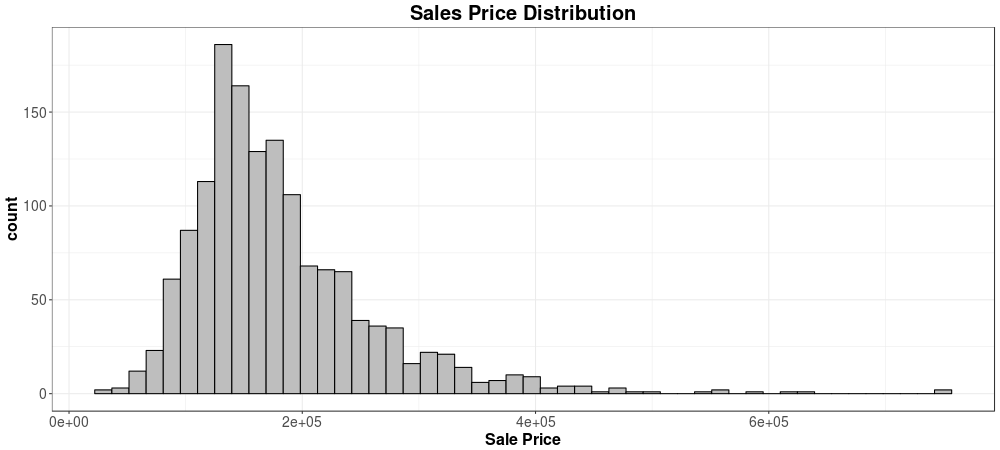

In [27]:
%%R -w 1000 -h 450 
ggplot(train, aes(x=SalePrice)) + 
        geom_histogram(color = 'black', fill = 'grey', bins = 50) + 
        theme_bw() +
        labs(x = 'Sale Price', title ="Sales Price Distribution") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

You can see that the target variable "SalePrice" has a skewed distribution. Because I will be predicting a continuous feature, I will be using regressors which perform better if the target variable has a normal distribution with little to no skewdness. Thus, it is important to remember that in a later stage the data needs to be normalized. 


### Numeric Features

Next, I will focus on the numeric features and see in what way they are related to the target variable. 
To do this, a correlation matrix is often the first step just to see what is exactly going on with the data. 
After that, I will look into some individual plots showing more on the relationship between that feature and the target. 

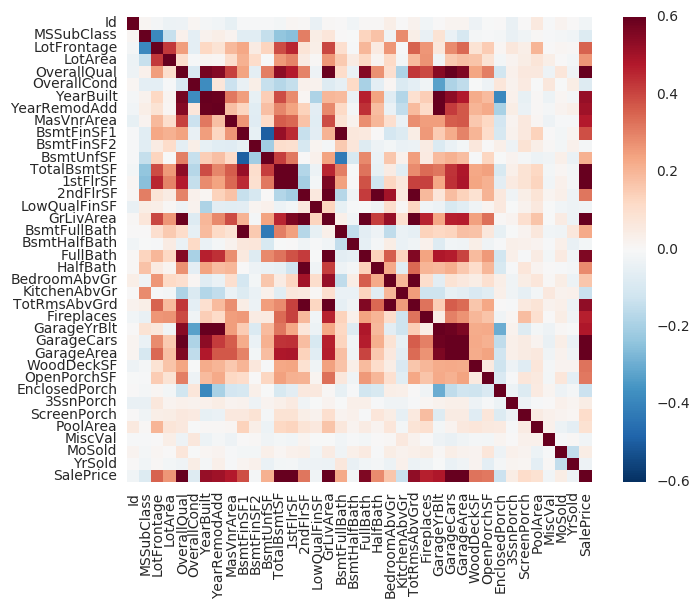

In [28]:
correlation_matrix = train.corr()
f, axis = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, vmax=.6, square=True);

There's a lot going on the in the correlation matrix. We see that there are some clusters that are highly correlated like GarageArea and GarageCars, which makes sense since having a garage that can hold more cars would likely also have a greater area. It is possible that there's some multicollinearity which affects the results.

Next, let's take a look at the features that are highly correlated with each other and look at those in more detail. I will select features that have a pearson's correlation of .7 or more. 

In [29]:
# Show highest correlation in the correlation matrix
correlation_matrix = train.corr().abs()
unstacked = correlation_matrix.unstack()
sort = unstacked.sort_values(kind="quicksort")
sort[(sort < 1) & (sort > 0.7)]

SalePrice     GrLivArea       0.708624
GrLivArea     SalePrice       0.708624
SalePrice     OverallQual     0.790982
OverallQual   SalePrice       0.790982
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
dtype: float64

Some things seems to be going on here:  
- There is some multicollinearity within the "Garage" features.
- SalePrice is higly correlated with OverallQual and GrLivArea
- Some people have bought a house without a garage and built the garage in later, which is why the correlation isn't 1

Next, I will look at all the features that have a high correlation with SalePrice. 

In [30]:
sort['SalePrice'][sort['SalePrice']>0.6]

1stFlrSF       0.605852
TotalBsmtSF    0.613581
GarageArea     0.623431
GarageCars     0.640409
GrLivArea      0.708624
OverallQual    0.790982
SalePrice      1.000000
dtype: float64

The overall quality of the house has the highest correlation with the sale price. The Garage seems to be an important feature, as well as the number of floors and whether it has a basement or not. Although we have a lot of numbers telling us a lot of things, it would be more intuitive if the data was actually visualized. The type of relation is not clear purely based on pearson's r, thus I will use a pairplot to plot all features that are highly correlated with SalePrice. 

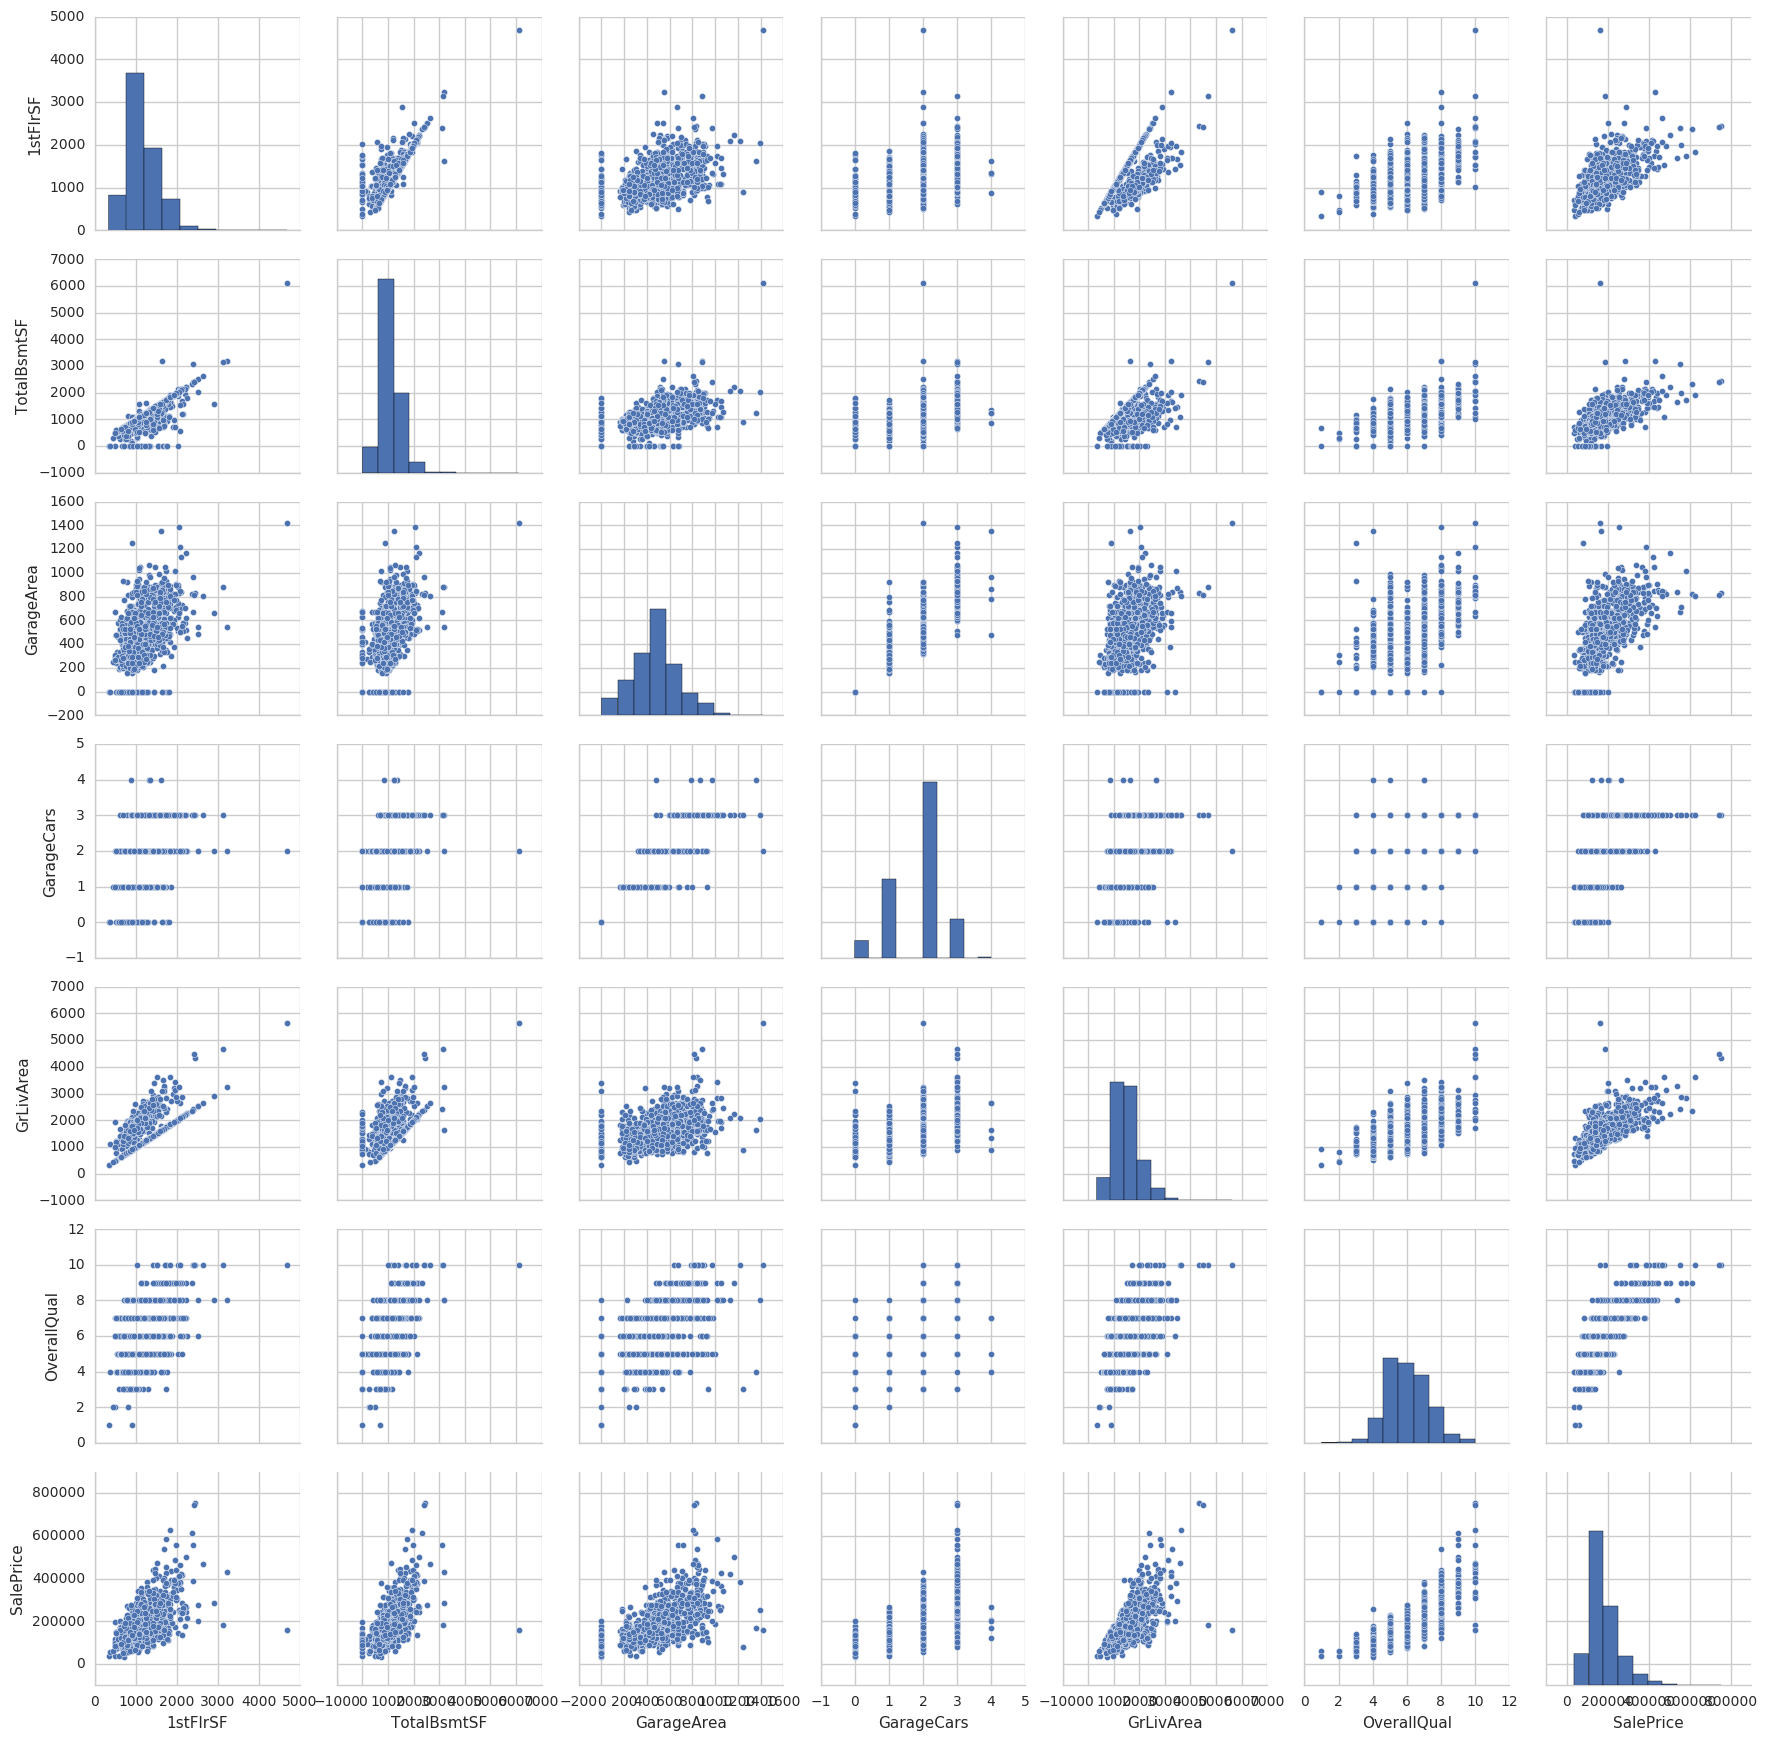

In [31]:
sns.set_style("whitegrid")
cols = sort['SalePrice'][sort['SalePrice']>0.6].index
sns.pairplot(train[cols], size = 2.5)
plt.show()

Although we now can clearly see the relationships, I also notice that a lot of features have some heteroscedasticity and some are not normally distributed. It might be worth to look into those features in more detail. 

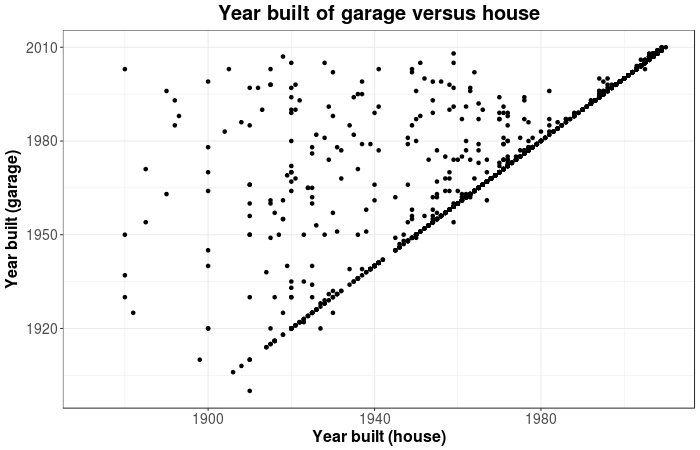

In [32]:
%%R -w 700 -h 450
ggplot(train, aes(x=YearBuilt, y=GarageYrBlt)) + 
        geom_point() + 
        theme_bw() + 
        labs( y = "Year built (garage)", x = 'Year built (house)', title ="Year built of garage versus house") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

This is really interesting to see! What happened is that most garages are built the same year as the house. However, some people either extended their garage or didn't have one and built that later. Everything on the line are the houses that had a garage from the beginning and most other point are those garages that were built later than the house. 

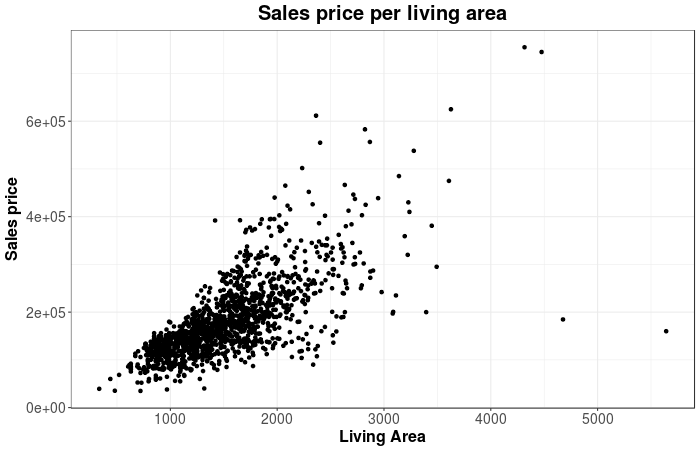

In [33]:
%%R -w 700 -h 450
ggplot(train, aes(y=SalePrice, x=GrLivArea)) + 
        geom_point() + 
        theme_bw() + 
        labs( y = "Sales price", x = 'Living Area', title ="Sales price per living area") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

There are two things that you should see immediately:
- There are two outliers on the far right (which we will deal with at a later stage)
- There is some heteroscedasticity going on (which we will also deal with later)

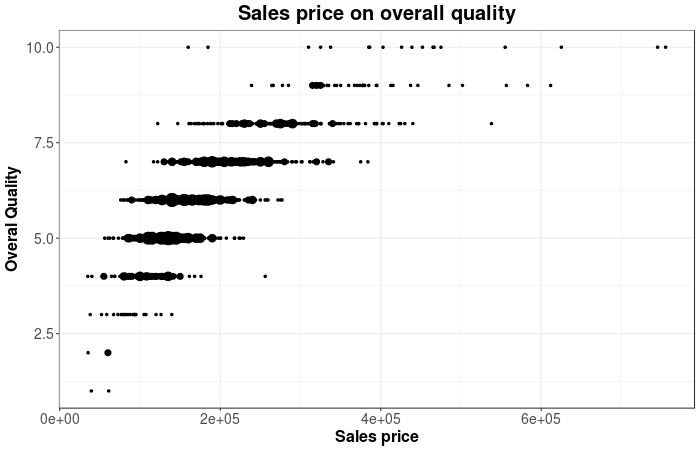

In [34]:
%%R -w 700 -h 450
ggplot(train, aes(x=SalePrice, y=OverallQual)) + 
        geom_count() + 
        theme_bw() + 
        labs( x = "Sales price", y = 'Overal Quality', title ="Sales price on overall quality") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

There clearly seems to be some relationship between overal quality and the sales price of the house such that an increase in sales price suggest an increase in overal quality.

### Categorical Features
Categorical features have been missing from the visualisation so far. Since there are too many combinations of features to visualize, I will focus on the categorical features that may (according to my intuition) be related to SalesPrice. 
Below is a list of categorical features in the dataset. 

In [35]:
train.dtypes[train.dtypes == "object"]

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

I will take a look at the following categories: SaleCondition and HouseStyle. 
Furthermore, I will see how they influence the visualizations that we've seen starting with SalePrice, LivingArea and SaleCondition. 

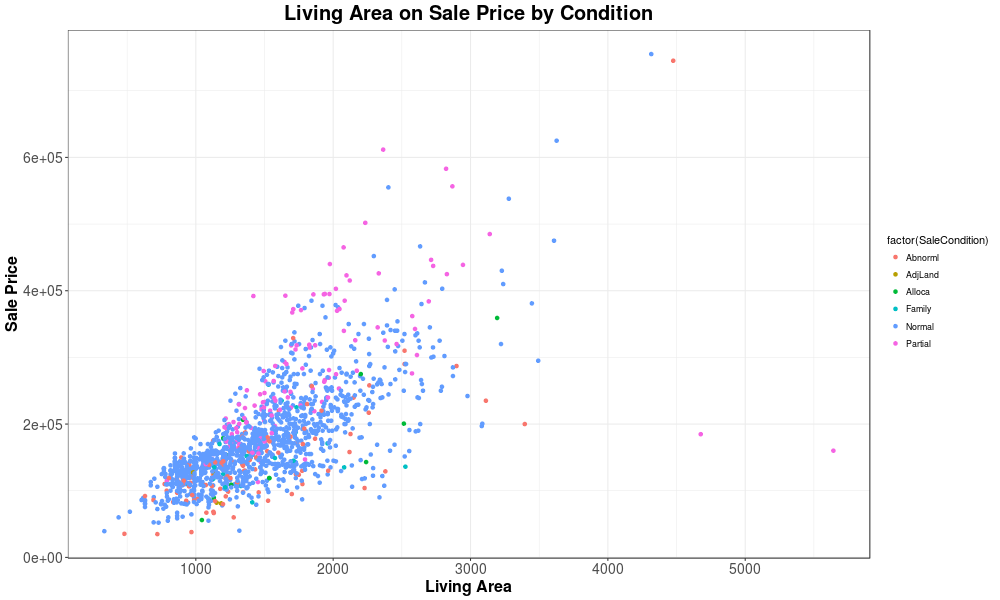

In [36]:
%%R -w 1000 -h 600
ggplot(train, aes(y=SalePrice, x=GrLivArea, color = factor(SaleCondition))) + 
        geom_point() +
        theme_bw() + 
        labs( x = "Living Area" , y = 'Sale Price', title ="Living Area on Sale Price by Condition") +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

The graph doesn't give much information. It may be then that the salecondition doens't influence the relationship between living area and saleprice. The main conclusion is that most houses seem to be of condition "Normal". Perhaps we see something different for neighborhood. 

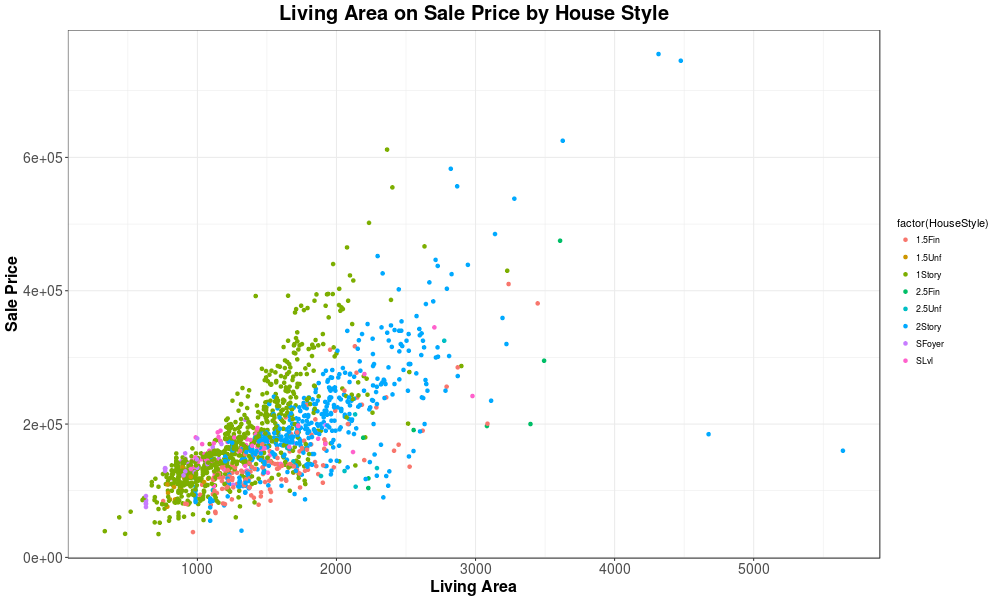

In [37]:
%%R -w 1000 -h 600
ggplot(train, aes(y=SalePrice, x=GrLivArea, color = factor(HouseStyle))) + 
        geom_point() +
        theme_bw() + 
        labs( x = "Living Area" , y = 'Sale Price', title ="Living Area on Sale Price by House Style") +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

There's definitely something different going on here. The 1 story houses are according to the plot the most expensive houses for each square feet of living area. You would get more area per dollar if you would buy a 2 story house. 

# Feature Engineering
Now that I've finished exploring the data it is time to work on some feature engineering. During the exploration several things came to my attention that I need to work on:
- There were some outliers
- The target feature is not normally distributed
- Some features showed heteroscedasticity
- Multicollinearity
    - Although multicollinearity was found in some features, I did not find any improvement in the scores if I deleted those features. Therefore, I simply let them be. 

Furthermore, I will be looking at:
- Variance of features
- Missing Values




### Outliers
In this machine learning task, it will be likely that I'll be using some form of regression analysis. These kind of methods are very sensitive to outliers, which may decrease the models accuracy. Therefore, I'll be looking for any outliers and remove them if neccesary. 

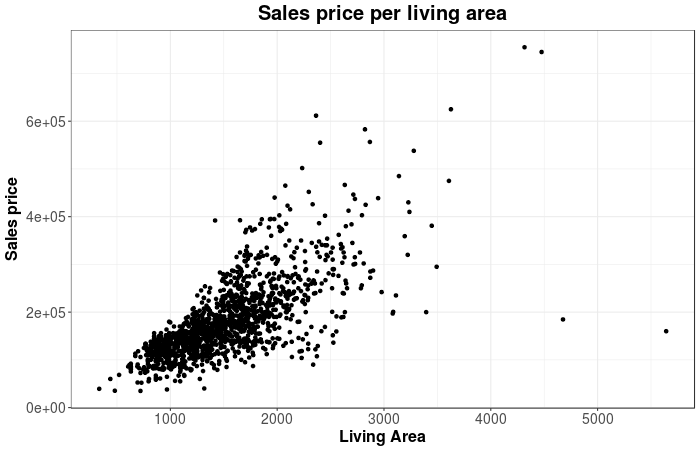

In [38]:
%%R -w 700 -h 450
ggplot(train, aes(y=SalePrice, x=GrLivArea)) + 
        geom_point() + 
        theme_bw() + 
        labs( y = "Sales price", x = 'Living Area', title ="Sales price per living area") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. Seeing the trends in the plot above I believe these two points to be outliers and not representative for the entire dataset. Thus, my initial conclusion is to delete those outliers. Luckily, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset which confirms my reasoning.   
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [39]:
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

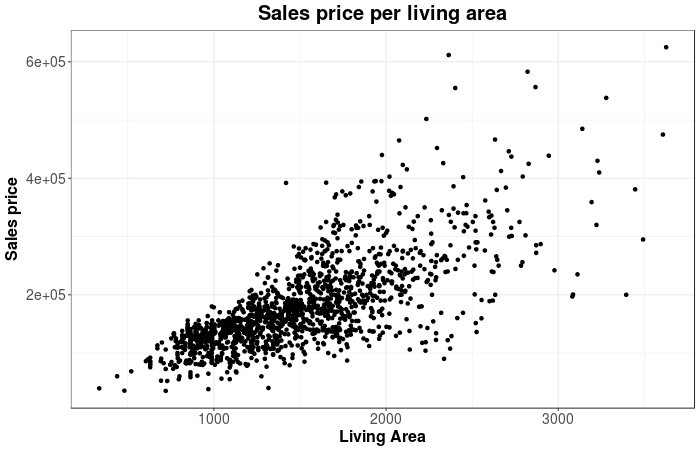

In [40]:
%%R -w 700 -h 450 -i train -i test
ggplot(train, aes(y=SalePrice, x=GrLivArea)) + 
        geom_point() + 
        theme_bw() + 
        labs( y = "Sales price", x = 'Living Area', title ="Sales price per living area") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

The new plot seems to look a lot better and more representative of the data. However, we also see the shape of a cone in the plot, which may suggest that there is something going on with the distribution of the variables. Next, I'll take a look at the distribution of the target variable. 

As a side note, the graph does display some *heteroscedasticity* which we will have to look into later (the cone-shape). 

**Combining Features**  
The data that was given was split into a test and train part. However, if I would want to transform categorical labels to numbers and I would do that only for the train set, then there might exist some levels/labels in the test set which we do not know. Therefore, I merge the test and train data so that I can get dummies (which I will do later) and create numbers for all labels. Furthermore, now I can also look for missing values in the test set. 

In [41]:
all_features = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], 
                          test.loc[:,'MSSubClass':'SaleCondition']))

### Missing Values

Often when there are many features, many don't have any values and are reported as NaN. In this dataset I find it highly unlikely that it was possible to report a value for everyone of the 81 features. Thus, I will create a list of the names of the columns that have missing values (solely based on NaN). This list can then be used to decide on what to do with those values. 

In [42]:
def count_missing_data(df):
    """ Counts the missing values for each features
        and display the Total and the Percentage
    """
    # Calculates the total number of missing values for each feature
    total = df.isnull().sum().sort_values(ascending=False)
    
    # Calculates the percentage of missing values for each features
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    
    # Combines the percentage and totals
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    # Only returns data that have missing values
    return missing_data[missing_data['Percent']>0]

print("Number of features with missing values: {}".format(len(count_missing_data(all_features))))
count_missing_data(all_features)

Number of features with missing values: 34


,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageFinish,159,0.054545


I will fill the missing values for the categorical features with the median using the function below. 

In [43]:
def fillna_numerica_average(df):
    """ Fills the numeric features that contain 
        NaN with the average in those columns
    """
    # Get features that contain missing values
    features_with_nan = count_missing_data(df).index 
    
    # Get numeric features that contain missing values
    numeric_missing_features = df[features_with_nan].dtypes[df.dtypes != "object"].index 
    
    # Fill each missing values for the numeric features with the corresponding median
    for feature in numeric_missing_features:
        df[feature].fillna(df[feature].median(), inplace=True)
        
fillna_numerica_average(all_features)

In [44]:
# Shows the missing values again, but seeing as we have filled all numerical features, the categorical features are left
list_missing_data = count_missing_data(all_features)
print("Number of features with missing values: {}".format(len(list_missing_data)))
print("Categorical features")
list_missing_data

Number of features with missing values: 23
Categorical features


,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
GarageCond,159,0.054545
GarageFinish,159,0.054545
GarageQual,159,0.054545
GarageType,157,0.053859
BsmtExposure,82,0.028130


I've tried filling the missing values for the categorical features with the mode, but that didn't help the score. Thus, I simply dropped all categorical features that have missing values. 

In [45]:
all_features = all_features.fillna(all_features.median())

**Things I tried, but didn't work...**  
I've tried some different methods for filling in the missing values. So far, simply taking the median of numeric features and taking the median of categoricals gave me the best score. I will list here what I have tried and my view on why it didn't work. 

- Filling the missing values for numerical features, for example GarageYrBlt, with 0. 
    - Since the corresponding feature "GarageCars" has the value 0 for the missing values in GarageYrBlt, this led me to think that there is no Garage for that house and GarageYrBlt cannot be filled with the median. However, 0 is technically also not correct, since no garage was built in the year 0. Dropping would make sense, but it lowered my score compared to filling it with the median. I may be overfitting the data or there actually may be a garage, but it cannot hold any cars. 
- Filling the missing values for categorical features, for example GarageType, with "No Garage"
    - Similarly, some categorical features were missing and using the mode didn't help the score, which assumes there are not other categories than is listed in the features. Since it didn't help, there might be more categories, which is why I figured that the missing values for GarageType meant that there was no garage. So I filled it with "No Garage", which also didn't help my score. Overfitting might have happened, but it may also be that there actually is a Garage. 

### Normality

**Why are we log transforming the features?**  
The models that I'm going to use are mostly (linear) regressors which use loss minimizers (or optimizers) like minimizing the RMSE. These models often perform better when the variables have standard deviation and means that are not too far apart. Thus, when doing a log() or sqrt() usually helps to reduce the scale of the variables so that they are closer to each other. However, it should be noted that log transforming the features is not common practice and should only be done if the features are highly skewed. Moreover, linear regression models have an important assumption, namely that of normality in the dependent variables. 

There are several ways to approach this problem:
- Calculating Skewness/kurtosis
- Using Kolmogorov-Smirnof test

The Kolmogorov-Smirnof test is used to compare the sample distribution to a normal distribution and then returns a p-value that will determine if the two distributions are similar. Kurtosis measure the taildness of the given distribution. Skeweness is a symmetry measure where distributions with 0 skew are of a normal shape. For skewness, we often look for values outside the range of -0.75 to 0.75 and for kurtosis outside the range of -3.0 to 3.0 which then doesn't satisfy the assumption for normality. 
All values that are not normally distributed, we can do a non-linear transformation like a log-transformation: f(x) = log(x+1). We're doing +1 when there might be 0's in the column seeing as log(0) = -∞. 

For the purpose of this notebook, I'll be using the Skewedness to calculate the normality. In a later version, I might extend this by adding a kurtosis and Kolmogorov-Smirnof test. 


**Skewness**  
I use the *skewness* here to identify distribution that are not normal, but I also could have use *kurtosis*. 
*Skewness* refers to how skewed the data is to the left or right of a normal distribution.  

<img src=https://www.kullabs.com/uploads/skewness1.jpg>
<br>
**Kurtosis**  
*Kurtosis* is an indication of how the tails and the peak of a distribution differ from the normal distribution. This is also why it tells you not much about the shape of the distribution and is the reason for choosing *skewness* over *kurtosis*. 
<br><br>


<center>**Positive Kurtosis**</center> | <center>**Negative Kurtosis**</center>
- | - 
<img src=http://support.minitab.com/en-us/minitab/17/distribution_plot_positive_kurtosis.png display= inline-block> | <img src=http://support.minitab.com/en-us/minitab/17/distribution_plot_negative_kurtosis.png display= inline-block>
<br>
**Distribution of the target variable**  
As an example, let's take the distribution of the target variable below.

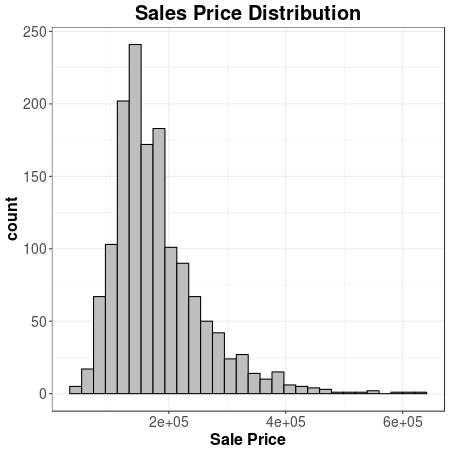

In [46]:
%%R -w 450 -h 450 
ggplot(train, aes(x=SalePrice)) + 
        geom_histogram(color = 'black', fill = 'grey', bins = 30) + 
        theme_bw() +
        labs(x = 'Sale Price', title ="Sales Price Distribution") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

Clearly, the distribution is skewed to the right, which means that we have to transform the current distribution to one that has a normal distribution. Below we will simply do that by computing the log(1+x) of all data points within the target variable. 

In [47]:
# #log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

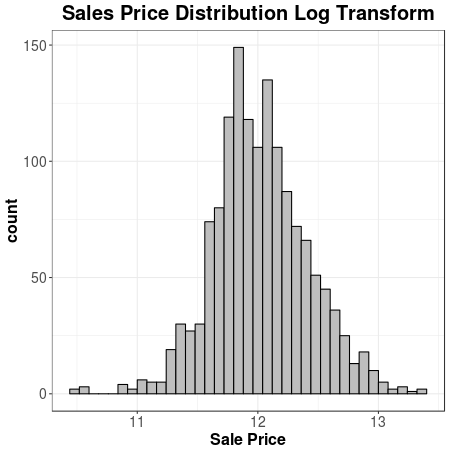

In [48]:
%%R -w 450 -h 450 -i train
ggplot(train, aes(x=SalePrice)) + 
        geom_histogram(color = 'black', fill = 'grey', binwidth=0.08, bins = 30) + 
        theme_bw() +
        labs(x = 'Sale Price', title ="Sales Price Distribution Log Transform") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

This already looks a lot better! Next, it would be wise to do the same for the independent variables that have a high skewedness.

In [49]:
# # Selecting only the numeric features
numeric_feature_names = all_features.dtypes[all_features.dtypes != "object"].index

# # Calculates the skewedness of the features and then gets the features with a skewedness above a certain threshold
skewed_features = train[numeric_feature_names].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.65].index

all_features[skewed_features] = np.log1p(all_features[skewed_features])

### Homoscedasticity (homogeneity of variance) 
Homoscedasticity is an assumption that the standard deviations of the error terms are constant and do not depend on the x-value. Basically, this means that each probability distribution for y has the same standard deviation regardless of the x-value. Thus, if all dependent variables exhibit the same levels of variance across predictor variables, then we have homoscedasticity and the assumption is not violated. We want the error term to be the same across all values of the independent variables. 

What may be easier to remember is that homoscedasticity means "same variance". It refers to situations in which the error term (i.e., noise) is the same across all values of the independent variables. In contrast, heteroscedasticity (which violates homoscedasticity) refers to situations in which the size of the error term is different across values of the independent variables. 

When we started plotting outliers, we saw that the graph displayed a cone. The shape of a cone violates the assumption of homoscedasticity since the error terms were not constant and seemed to increase with an increase of x. What we would like to see is the same variance at every x. Luckily, we've already normalized the data (which often also removes the violation of the assumption of homoscedasticity). Let's check that below. 

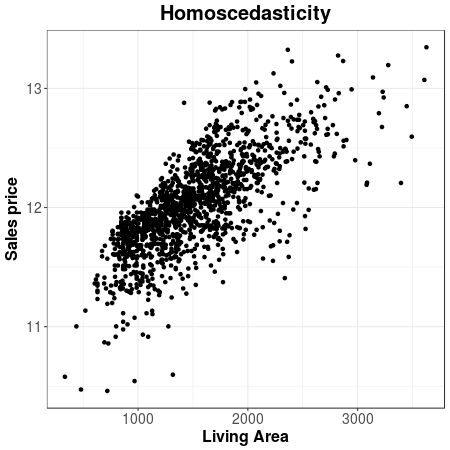

In [50]:
%%R -w 450 -h 450 
ggplot(train, aes(y=SalePrice, x=GrLivArea)) + 
        geom_point() + 
        theme_bw() + 
        labs( y = "Sales price", x = 'Living Area', title ="Homoscedasticity") +
        theme(legend.position="none", axis.text=element_text(size=14), axis.title=element_text(size=16,face="bold"),
             plot.title = element_text(lineheight=1, face="bold", size=20, hjust = 0.5))

We can clearly see that the shape of a cone does not exist anymore and the graph follow more the pattern of equal variances. Thus, we don't have to any data manipulation to make sure that the assumption of homoscedasticity is met. 

**Transforming Categorical Features**  
If I would simply label the categorical features, then that would imply some meaning in the distances between data points, that is not the case. Thus, I choose to make dummy features of all categorical features so that they will displayed as having some category or not.  

In [51]:
all_features = pd.get_dummies(all_features)

**Scaling Features**  
Scaling all the numeric features so that they will have a better distribution

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(all_features[numeric_feature_names])
scaled = scaler.transform(all_features[numeric_feature_names])

### Variance Threshold
Here, I'm selecting features for which most values are the same. If most values are the same for a certain feature, then it only adds noise and will likely make our model overfit the data. Thus, we drop the features that have a low variance (which significantly improved my score). 

In [53]:
from sklearn.feature_selection import VarianceThreshold

In [54]:
variance = VarianceThreshold(0.01)
all_features = variance.fit_transform(all_features)

# Modeling

In [55]:
import xgboost as xgb
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

**RMSE**  
The root mean squared error (RMSE) is a quadratic scoring real that measures the average magniute of the error. It takes the square root of the average of squared differences between prediction and actual observation. This is mostly used to measure the accuracy of continuous variables. The formula for RMSE is as follows: $RMSE = {\sqrt {\frac{1} {n}{\sum\limits_{j = 1}^n {(y_{j} - \hat{y}_{i} } })^{2} } }$. One benefit of RMSE is that is penalizes large errors more, which can be helpfull in certain cases. If you are off by 10, then that is more than twice as bad as being off by 5. 

In [56]:
from sklearn.model_selection import cross_val_score

def rmse_cross_validation(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Because we concatenated the data in an earlier stage, we can simply use the shape of the train data to mark where we have added the test data so that we can split all_features into X_train and X_test. That way, we have the same data that was in the training dataset and in the testing dataset.

In [57]:
y_train = train['SalePrice']

X_train = all_features[:train.shape[0]]
X_test = all_features[train.shape[0]:]

**Ridge Regression**  
Ridge regression is a method that redues the size of coefficients in a linear regression using the L2 norm (see below) and thereby reduces the complexity in the model. Furthermore, it helps in overfitting and dealing with outliers. 

The L2 norm means that the weight (which you find in a linear regression) are penalized if they were to grow to large. This way you won't put too much emphasis on a few features, but you make sure the weights are similar. Therefore, it also helps with generalization and makes it more robust. 

**Lasso**  
Lasso (Least Absolute Shrinkage and Selection Operator) also uses regulization to prevent overfitting. In contrast, however, it can set the weights of coefficients to zero, whereas ridge regression can only bring those close to zero but never zero. Therefore, lasso often is a model that is less complex since it can fully remove features. In our case, it helps with the highly correlated predictors. 

**ElasticNet**  
Elastic net solves the limitations of lasso and ridge, while also including each as special cases. It uses both the L1 and the L2 norm. In layman-terms, it combines the penalties of lasso and ridge and it often prefered above both models. 

**Gradient Booster**  
The gradient booster basically takes many weak predictive models and boosts it into a stronger one, which represents an ensemble of weak models. Often, the weak model can be any model that works a little better than a random guess. 

**XGBoost**  
XGBoost is very similar to a gradient booster in that it follows gradient boosting. XGBoost uses a more regularized model formalization to control over-fitting, which gives it better performance.

### GridSearch
I use a grid search to find the best parameters for each model. Each model has its own parameter grid, which can be used to specify the parameters. I suggest you don't execute this part, seeing as it will take forever to find all the best parameters. 

In [ ]:
def grid_search(param_grid, estimator):
    grid = GridSearchCV(estimator,param_grid,refit=True,verbose=3)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)

In [ ]:
param_grid_gradient = {'n_estimators': [500, 3000], 
              'learning_rate': np.arange(0.01, 0.1, 0.01), 
              'max_depth': [1, 3, 5, 7], 
             'min_samples_leaf': [10, 15, 20],
             'min_samples_split': [10, 15, 20]}

param_grid_xgb = {'colsample_bytree' :[0.2],
                 'gamma': [0.0],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'min_child_weight': [1.5],
                 'n_estimators': np.arange(5000, 30000, 5000),                                                          
                 'reg_alpha': [0.9],
                 'reg_lambda': [0.6],
                 'subsample': [0.2, 0.3],
                'max_depth': [1, 2, 3, 4]}

param_grid_lasso = {'alpha':np.arange(0.0001, 0.001, 0.0001), 
                    'max_iter': np.arange(10000, 50000, 10000)}

param_grid_net = {'alpha': np.arange(0.0001, 0.001, 0.0001)}

param_grid_ridge = {'alpha': np.arange(0.1, 0.9, 0.1), 
                    'kernel': ['polynomial'], 
                    'degree': [2], 
                    'coef0':[1.85]} 

# grid_search(param_grid_gradient, GradientBoostingRegressor())
# grid_search(param_grid_xgb, XGBRegressor())
# grid_search(param_grid_lasso, Lasso())
# grid_search(param_grid_net, ElasticNet())
# grid_search(param_grid_ridge, KernelRidge())

## Training Models
Here the models are trained and test on the X_train and X_test data to measure its performance. The parameters used are the ones I found using a grid search for each model. 

Based on the prediction scores, I devised a ensemble of multiple predictors using certain weights. I found dat XGB and ElasticNet gave me the best scores, so I increased the weight of those predictors so that those would dominate the output. All the other predictors are then used to slightly adjust the dominating predictors to avoid overfitting. 

In [ ]:
# Gradient Boosting
gradient = GradientBoostingRegressor(n_estimators = 3000, min_samples_leaf = 15, learning_rate = 0.05, max_features = 'sqrt',
                                      max_depth = 3, min_samples_split = 10, loss = 'huber')
gradient.fit(X_train, y_train)
y_pred_gradient = gradient.predict(X_train)

# XGBoost
xgb = xgb.XGBRegressor(n_estimators = 30000, colsample_bytree = 0.2, gamma = 0.0,  reg_lambda = 0.6,  min_child_weight = 1.5,
                  reg_alpha = 0.9, learning_rate = 0.01, max_depth = 4, subsample = 0.2, seed = 42, silent = 1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_train)

# Lasso
lasso = Lasso(max_iter = 50000, alpha = 0.00098)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_train)

# ElasticNet
net = ElasticNet(alpha=0.001)
net.fit(X_train, y_train)
y_pred_net = net.predict(X_train)

# Ridge
ridge = KernelRidge(alpha = 0.3, coef0 = 1.85, kernel = 'polynomial', degree = 2)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_train)

In [ ]:
# Averaging scores using weights
y_pred = (0.70*y_pred_xgb + 0.05*y_pred_lasso + 0.15*y_pred_net + 0.05*y_pred_ridge + 0.05*y_pred_gradient)

In [ ]:
# print('XGBoost CV RMSE: {}'.format(rmse_cross_validation(xgb)))
# print('Lasso CV RMSE: {}'.format(rmse_cross_validation(lasso)))
# print('ElasticNet CV RMSE: {}'.format(rmse_cross_validation(net)))
# print('Ridge CV RMSE: {}'.format(rmse_cross_validation(ridge)))
# print('Gradient CV RMSE: {}'.format(rmse_cross_validation(gradient)))
# print('Averaging Ensemble RMSE: {}'.format(rmse(y_train, y_pred)))

## Submission
Below is mostly the same code as above. The only change is that I predict the X_test instead of y so that I can submit my predictions. A file is created that is used for submission with the correct structure. It should be noted that since I've not set a seed, the results are somewhat randomized and the submission may slightly be different from the leaderboard score. 

In [20]:
# Lasso
lasso = Lasso(max_iter = 50000, alpha = 0.00098)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# ElasticNet
net = ElasticNet(alpha = 0.001)
net.fit(X_train, y_train)
y_pred_net = net.predict(X_test)

# Ridge
ridge = KernelRidge(alpha = 0.3, coef0 = 1.8, kernel = 'polynomial', degree = 2)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Gradient boosting
gradient = GradientBoostingRegressor(n_estimators = 3000, min_samples_leaf = 15, learning_rate = 0.05, max_features = 'sqrt',
                                      max_depth = 3, min_samples_split = 10, loss = 'huber', random_state = 42)
gradient.fit(X_train, y_train)
y_pred_gradient = gradient.predict(X_test)

# XGBoost
xgb = xgb.XGBRegressor(n_estimators = 35000, colsample_bytree = 0.2, reg_lambda = 0.6,  min_child_weight = 1.5,
                  reg_alpha = 0.9, learning_rate = 0.01, max_depth = 4, subsample = 0.2, seed = 42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [21]:
# Averaging Scores
y_pred = (3*y_pred_xgb + y_pred_lasso + 3.6*y_pred_net + 1.5*y_pred_ridge + 2*y_pred_gradient) / 11.1

# y_pred = (3*y_pred_xgb + y_pred_lasso + 3.6*y_pred_net + y_pred_ridge + 2*y_pred_gradient) / 10.6

In [22]:
solution = pd.DataFrame({"id":test.Id, "SalePrice": np.expm1(y_pred)})
# solution.to_csv("submission.csv", index = False)